# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

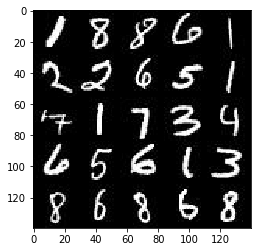

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

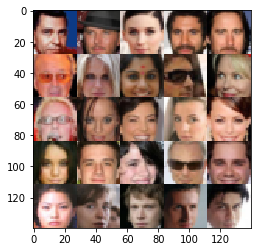

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3 or 28x28x1
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha*x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 7x7x128

        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # 4x4x256
        
        flat = tf.reshape(x2, [-1, 4*4*256])        
        logits = tf.layers.dense(flat, 1, activation=None)
        output = tf.sigmoid(logits)

        return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 4*4*512)
        x1 = tf.reshape(x1, [-1, 4, 4, 512])
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        # 4x4x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
        # 8x8x256
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)
        # 16x16x128
        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.image.resize_images(logits, (28, 28))
        output = tf.tanh(logits)
        # 28x28xout_channel_dim

        return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    
def plot_losses(d_loss, g_loss):
    fig, ax = pyplot.subplots()
    pyplot.plot(d_loss, label='Discriminator', alpha=0.5)
    pyplot.plot(g_loss, label='Generator', alpha=0.5)
    pyplot.title("Training Losses")
    pyplot.legend()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = 3 if data_image_mode == 'RGB' else 1
    
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)    

    loss_d, loss_g = [], []
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                
                step += 1
                
                if step % 10 == 0:
                    train_loss_g = sess.run(g_loss, feed_dict={input_z: batch_z})
                    train_loss_d = sess.run(d_loss, feed_dict={input_z: batch_z, input_real: batch_images})
                    loss_d.append(train_loss_d)
                    loss_g.append(train_loss_g)
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % 200 == 0:
                    show_generator_output(sess, 16, input_z, image_channels, data_image_mode)

        print("Final Output:")
        show_generator_output(sess, 16, input_z, image_channels, data_image_mode)
        plot_losses(loss_d, loss_g)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4244... Generator Loss: 0.5246
Epoch 1/2... Discriminator Loss: 1.2990... Generator Loss: 0.6722
Epoch 1/2... Discriminator Loss: 1.4750... Generator Loss: 0.6020
Epoch 1/2... Discriminator Loss: 1.3316... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.2373... Generator Loss: 0.6560
Epoch 1/2... Discriminator Loss: 1.1933... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 0.7176
Epoch 1/2... Discriminator Loss: 1.1864... Generator Loss: 0.7826
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.7578
Epoch 1/2... Discriminator Loss: 1.1210... Generator Loss: 0.8345
Epoch 1/2... Discriminator Loss: 1.0706... Generator Loss: 0.8428
Epoch 1/2... Discriminator Loss: 1.0170... Generator Loss: 0.9189
Epoch 1/2... Discriminator Loss: 0.9106... Generator Loss: 1.0047
Epoch 1/2... Discriminator Loss: 0.9230... Generator Loss: 1.0009
Epoch 1/2... Discriminator Loss: 0.9436... Generator Loss: 0.9456
Epoch 1/2.

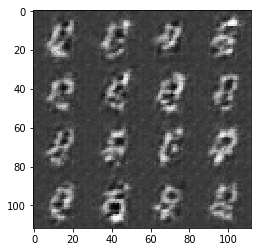

Epoch 1/2... Discriminator Loss: 0.8734... Generator Loss: 1.0725
Epoch 1/2... Discriminator Loss: 0.8340... Generator Loss: 1.0936
Epoch 1/2... Discriminator Loss: 0.8433... Generator Loss: 1.1074
Epoch 1/2... Discriminator Loss: 0.8244... Generator Loss: 1.0967
Epoch 1/2... Discriminator Loss: 0.8558... Generator Loss: 1.1713
Epoch 1/2... Discriminator Loss: 0.8033... Generator Loss: 1.2278
Epoch 1/2... Discriminator Loss: 0.7760... Generator Loss: 1.2342
Epoch 1/2... Discriminator Loss: 0.6856... Generator Loss: 1.2710
Epoch 1/2... Discriminator Loss: 0.6992... Generator Loss: 1.2516
Epoch 1/2... Discriminator Loss: 0.6633... Generator Loss: 1.2621
Epoch 1/2... Discriminator Loss: 0.6808... Generator Loss: 1.2349
Epoch 1/2... Discriminator Loss: 0.6254... Generator Loss: 1.4587
Epoch 1/2... Discriminator Loss: 0.6681... Generator Loss: 1.3083
Epoch 1/2... Discriminator Loss: 0.6180... Generator Loss: 1.3339
Epoch 1/2... Discriminator Loss: 0.6851... Generator Loss: 1.3115
Epoch 1/2.

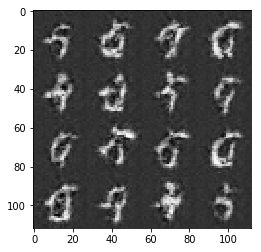

Epoch 1/2... Discriminator Loss: 0.5436... Generator Loss: 1.4592
Epoch 1/2... Discriminator Loss: 0.5418... Generator Loss: 1.5921
Epoch 1/2... Discriminator Loss: 0.4727... Generator Loss: 1.6436
Epoch 1/2... Discriminator Loss: 0.4917... Generator Loss: 1.5534
Epoch 1/2... Discriminator Loss: 0.5180... Generator Loss: 1.5943
Epoch 1/2... Discriminator Loss: 0.4761... Generator Loss: 1.5951
Epoch 2/2... Discriminator Loss: 0.4293... Generator Loss: 1.7711
Epoch 2/2... Discriminator Loss: 0.4610... Generator Loss: 1.7262
Epoch 2/2... Discriminator Loss: 0.4359... Generator Loss: 1.8375
Epoch 2/2... Discriminator Loss: 0.4266... Generator Loss: 1.9723
Epoch 2/2... Discriminator Loss: 0.5177... Generator Loss: 1.7747
Epoch 2/2... Discriminator Loss: 0.4854... Generator Loss: 1.4683
Epoch 2/2... Discriminator Loss: 0.3989... Generator Loss: 1.8234
Epoch 2/2... Discriminator Loss: 0.5329... Generator Loss: 1.9243
Epoch 2/2... Discriminator Loss: 0.4835... Generator Loss: 1.7297
Epoch 2/2.

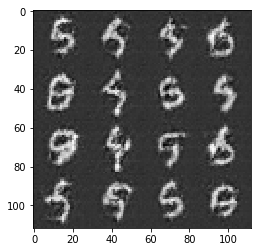

Epoch 2/2... Discriminator Loss: 0.9775... Generator Loss: 0.7202
Epoch 2/2... Discriminator Loss: 0.4894... Generator Loss: 1.7684
Epoch 2/2... Discriminator Loss: 0.4746... Generator Loss: 1.5430
Epoch 2/2... Discriminator Loss: 0.4325... Generator Loss: 1.7539
Epoch 2/2... Discriminator Loss: 0.3989... Generator Loss: 2.2512
Epoch 2/2... Discriminator Loss: 0.4248... Generator Loss: 1.7805
Epoch 2/2... Discriminator Loss: 0.4078... Generator Loss: 1.7668
Epoch 2/2... Discriminator Loss: 0.4699... Generator Loss: 1.7366
Epoch 2/2... Discriminator Loss: 0.4244... Generator Loss: 1.6834
Epoch 2/2... Discriminator Loss: 0.4162... Generator Loss: 1.6175
Epoch 2/2... Discriminator Loss: 0.4562... Generator Loss: 1.7414
Epoch 2/2... Discriminator Loss: 0.5721... Generator Loss: 1.8769
Epoch 2/2... Discriminator Loss: 0.5102... Generator Loss: 1.6670
Epoch 2/2... Discriminator Loss: 0.4447... Generator Loss: 2.1527
Epoch 2/2... Discriminator Loss: 0.4846... Generator Loss: 1.6009
Epoch 2/2.

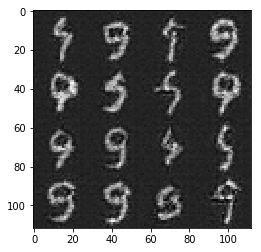

Epoch 2/2... Discriminator Loss: 0.4602... Generator Loss: 2.0752
Epoch 2/2... Discriminator Loss: 0.5645... Generator Loss: 1.5288
Epoch 2/2... Discriminator Loss: 0.5061... Generator Loss: 1.7534
Epoch 2/2... Discriminator Loss: 0.8583... Generator Loss: 1.8877
Epoch 2/2... Discriminator Loss: 0.5800... Generator Loss: 1.6820
Epoch 2/2... Discriminator Loss: 0.4655... Generator Loss: 1.6060
Epoch 2/2... Discriminator Loss: 0.4749... Generator Loss: 1.7876
Epoch 2/2... Discriminator Loss: 0.4355... Generator Loss: 1.7694
Epoch 2/2... Discriminator Loss: 0.5015... Generator Loss: 2.1822
Epoch 2/2... Discriminator Loss: 0.3893... Generator Loss: 1.9369
Epoch 2/2... Discriminator Loss: 0.5384... Generator Loss: 1.8185
Epoch 2/2... Discriminator Loss: 0.5404... Generator Loss: 1.4070
Epoch 2/2... Discriminator Loss: 0.3794... Generator Loss: 1.7478
Final Output:


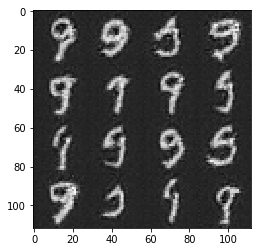

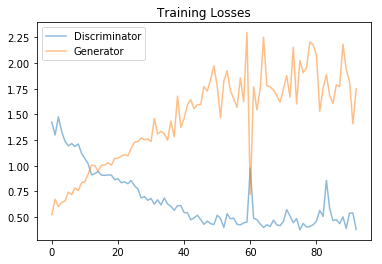

In [12]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8533... Generator Loss: 0.3645
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.5740
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.6233
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.6988
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.1671... Generator Loss: 0.6760
Epoch 1/1.

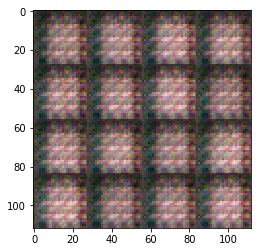

Epoch 1/1... Discriminator Loss: 1.1219... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.0676... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 0.8489... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 0.9168... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 0.9412... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 0.8772... Generator Loss: 1.0008
Epoch 1/1... Discriminator Loss: 0.8590... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 0.7365... Generator Loss: 1.2377
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.1867
Epoch 1/1... Discriminator Loss: 1.0433... Generator Loss: 0.8558
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 0.9700
Epoch 1/1... Discriminator Loss: 0.9499... Generator Loss: 0.9721
Epoch 1/1... Discriminator Loss: 0.8289... Generator Loss: 1.0925
Epoch 1/1... Discriminator Loss: 0.9344... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 0.8711... Generator Loss: 1.1218
Epoch 1/1.

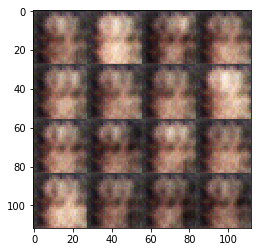

Epoch 1/1... Discriminator Loss: 0.6242... Generator Loss: 1.4107
Epoch 1/1... Discriminator Loss: 0.7906... Generator Loss: 1.3350
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 1.3436
Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.4944
Epoch 1/1... Discriminator Loss: 0.7579... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 1.1842
Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 0.6630... Generator Loss: 1.5618
Epoch 1/1... Discriminator Loss: 0.9077... Generator Loss: 0.8978
Epoch 1/1... Discriminator Loss: 0.6481... Generator Loss: 1.3009
Epoch 1/1... Discriminator Loss: 0.5680... Generator Loss: 1.4385
Epoch 1/1... Discriminator Loss: 0.6227... Generator Loss: 1.4705
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.3974
Epoch 1/1... Discriminator Loss: 0.5969... Generator Loss: 1.4823
Epoch 1/1... Discriminator Loss: 0.7240... Generator Loss: 1.2130
Epoch 1/1.

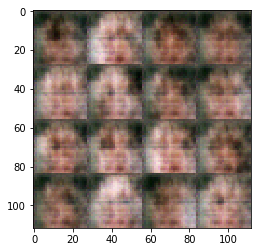

Epoch 1/1... Discriminator Loss: 0.6748... Generator Loss: 1.2059
Epoch 1/1... Discriminator Loss: 0.5958... Generator Loss: 1.4178
Epoch 1/1... Discriminator Loss: 0.4250... Generator Loss: 2.0970
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 1.9422
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 1.6684
Epoch 1/1... Discriminator Loss: 0.5997... Generator Loss: 1.3763
Epoch 1/1... Discriminator Loss: 0.5839... Generator Loss: 1.6992
Epoch 1/1... Discriminator Loss: 0.5336... Generator Loss: 1.6765
Epoch 1/1... Discriminator Loss: 0.4474... Generator Loss: 1.9006
Epoch 1/1... Discriminator Loss: 0.4509... Generator Loss: 2.5312
Epoch 1/1... Discriminator Loss: 0.3593... Generator Loss: 2.0733
Epoch 1/1... Discriminator Loss: 0.3245... Generator Loss: 2.2258
Epoch 1/1... Discriminator Loss: 0.3680... Generator Loss: 2.0775
Epoch 1/1... Discriminator Loss: 0.3426... Generator Loss: 2.1773
Epoch 1/1... Discriminator Loss: 0.2868... Generator Loss: 2.5465
Epoch 1/1.

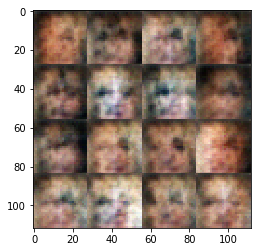

Epoch 1/1... Discriminator Loss: 0.5387... Generator Loss: 1.4691
Epoch 1/1... Discriminator Loss: 0.4394... Generator Loss: 1.6008
Epoch 1/1... Discriminator Loss: 0.7755... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 0.2875... Generator Loss: 3.2587
Epoch 1/1... Discriminator Loss: 0.2820... Generator Loss: 2.9181
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 2.2872
Epoch 1/1... Discriminator Loss: 0.2659... Generator Loss: 2.5367
Epoch 1/1... Discriminator Loss: 0.2312... Generator Loss: 3.1851
Epoch 1/1... Discriminator Loss: 0.6552... Generator Loss: 1.4159
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 2.3270
Epoch 1/1... Discriminator Loss: 0.3807... Generator Loss: 2.1611
Epoch 1/1... Discriminator Loss: 0.3103... Generator Loss: 2.6651
Epoch 1/1... Discriminator Loss: 0.2690... Generator Loss: 2.7985
Epoch 1/1... Discriminator Loss: 0.2706... Generator Loss: 3.0441
Epoch 1/1... Discriminator Loss: 0.4877... Generator Loss: 2.2635
Epoch 1/1.

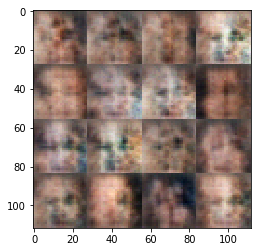

Epoch 1/1... Discriminator Loss: 0.7238... Generator Loss: 1.5300
Epoch 1/1... Discriminator Loss: 0.5698... Generator Loss: 1.7681
Epoch 1/1... Discriminator Loss: 0.3486... Generator Loss: 3.1132
Epoch 1/1... Discriminator Loss: 0.2468... Generator Loss: 2.9111
Epoch 1/1... Discriminator Loss: 0.2970... Generator Loss: 2.3423
Epoch 1/1... Discriminator Loss: 0.3719... Generator Loss: 2.4632
Epoch 1/1... Discriminator Loss: 0.2387... Generator Loss: 3.2500
Epoch 1/1... Discriminator Loss: 0.3120... Generator Loss: 2.6791
Epoch 1/1... Discriminator Loss: 0.3957... Generator Loss: 2.6635
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 2.1501
Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 3.1195
Epoch 1/1... Discriminator Loss: 0.3899... Generator Loss: 2.7775
Epoch 1/1... Discriminator Loss: 0.3224... Generator Loss: 3.3005
Epoch 1/1... Discriminator Loss: 0.3823... Generator Loss: 2.4808
Epoch 1/1... Discriminator Loss: 0.3043... Generator Loss: 2.6214
Epoch 1/1.

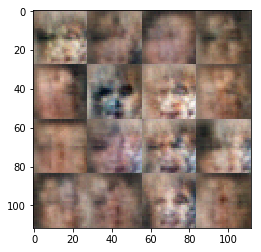

Epoch 1/1... Discriminator Loss: 1.1287... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 0.2823... Generator Loss: 2.7921
Epoch 1/1... Discriminator Loss: 0.4541... Generator Loss: 2.1134
Epoch 1/1... Discriminator Loss: 0.3518... Generator Loss: 2.5044
Epoch 1/1... Discriminator Loss: 0.3706... Generator Loss: 3.6242
Epoch 1/1... Discriminator Loss: 0.2999... Generator Loss: 4.7040
Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.8310
Epoch 1/1... Discriminator Loss: 2.7660... Generator Loss: 1.5055
Epoch 1/1... Discriminator Loss: 0.9177... Generator Loss: 1.0994
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.7639
Epoch 1/1... Discriminator Loss: 0.4092... Generator Loss: 1.9935
Epoch 1/1... Discriminator Loss: 0.6237... Generator Loss: 1.7244
Epoch 1/1... Discriminator Loss: 0.9188... Generator Loss: 0.8556
Epoch 1/1... Discriminator Loss: 0.4418... Generator Loss: 1.9569
Epoch 1/1... Discriminator Loss: 0.6401... Generator Loss: 1.2085
Epoch 1/1.

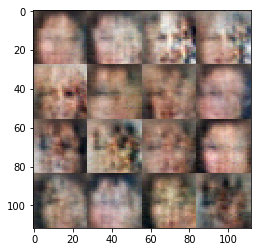

Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 1.6778
Epoch 1/1... Discriminator Loss: 0.6583... Generator Loss: 1.9713
Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 0.5727... Generator Loss: 1.6375
Epoch 1/1... Discriminator Loss: 0.5455... Generator Loss: 1.6668
Epoch 1/1... Discriminator Loss: 0.8431... Generator Loss: 0.9696
Epoch 1/1... Discriminator Loss: 0.5685... Generator Loss: 3.2923
Epoch 1/1... Discriminator Loss: 0.6567... Generator Loss: 1.3950
Epoch 1/1... Discriminator Loss: 0.6993... Generator Loss: 1.1868
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 0.6891... Generator Loss: 1.9439
Epoch 1/1... Discriminator Loss: 0.6028... Generator Loss: 1.4741
Epoch 1/1... Discriminator Loss: 0.4185... Generator Loss: 3.0795
Epoch 1/1... Discriminator Loss: 0.7574... Generator Loss: 1.2406
Epoch 1/1... Discriminator Loss: 0.7096... Generator Loss: 1.2727
Epoch 1/1.

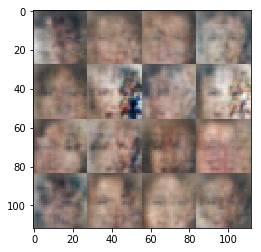

Epoch 1/1... Discriminator Loss: 0.9158... Generator Loss: 1.1490
Epoch 1/1... Discriminator Loss: 0.5813... Generator Loss: 1.8035
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 1.6847
Epoch 1/1... Discriminator Loss: 1.0499... Generator Loss: 1.0686
Epoch 1/1... Discriminator Loss: 0.7387... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.0655... Generator Loss: 0.7779
Epoch 1/1... Discriminator Loss: 0.8755... Generator Loss: 2.2945
Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.2120
Epoch 1/1... Discriminator Loss: 1.2045... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.9224
Epoch 1/1... Discriminator Loss: 0.5202... Generator Loss: 2.5961
Epoch 1/1... Discriminator Loss: 0.9586... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 0.8943... Generator Loss: 1.0564
Epoch 1/1... Discriminator Loss: 0.8873... Generator Loss: 1.1116
Epoch 1/1... Discriminator Loss: 0.5221... Generator Loss: 2.8568
Epoch 1/1.

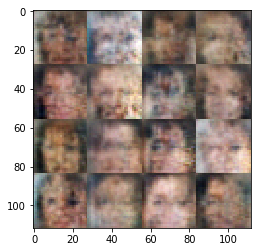

Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.8745
Epoch 1/1... Discriminator Loss: 0.9228... Generator Loss: 0.9638
Epoch 1/1... Discriminator Loss: 0.6596... Generator Loss: 1.5244
Epoch 1/1... Discriminator Loss: 0.7371... Generator Loss: 1.4959
Epoch 1/1... Discriminator Loss: 0.7528... Generator Loss: 1.3996
Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 0.5374... Generator Loss: 1.9337
Epoch 1/1... Discriminator Loss: 1.1582... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 0.7022... Generator Loss: 1.2653
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 0.7543... Generator Loss: 1.5291
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.1825
Epoch 1/1... Discriminator Loss: 1.0052... Generator Loss: 0.9796
Epoch 1/1... Discriminator Loss: 0.8619... Generator Loss: 1.1391
Epoch 1/1... Discriminator Loss: 0.9895... Generator Loss: 0.9155
Epoch 1/1.

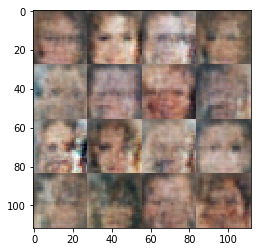

Epoch 1/1... Discriminator Loss: 1.0141... Generator Loss: 1.1192
Epoch 1/1... Discriminator Loss: 0.9150... Generator Loss: 1.0533
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.0147
Epoch 1/1... Discriminator Loss: 0.7217... Generator Loss: 1.1806
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 1.1884
Epoch 1/1... Discriminator Loss: 0.8031... Generator Loss: 1.5992
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.3329
Epoch 1/1... Discriminator Loss: 0.8403... Generator Loss: 1.3053
Epoch 1/1... Discriminator Loss: 0.9812... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.8385
Epoch 1/1... Discriminator Loss: 0.9336... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 0.9697... Generator Loss: 1.1345
Epoch 1/1... Discriminator Loss: 1.0179... Generator Loss: 0.9614
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 0.9728
Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 0.9838
Epoch 1/1.

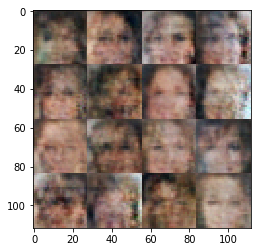

Epoch 1/1... Discriminator Loss: 0.6836... Generator Loss: 1.8329
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 0.9014... Generator Loss: 1.0076
Epoch 1/1... Discriminator Loss: 1.1159... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.2956
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 1.6926
Epoch 1/1... Discriminator Loss: 1.0378... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.0149... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 0.8471
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.8532
Epoch 1/1... Discriminator Loss: 0.6162... Generator Loss: 1.9830
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 0.9704... Generator Loss: 0.8723
Epoch 1/1... Discriminator Loss: 0.9258... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.3164
Epoch 1/1.

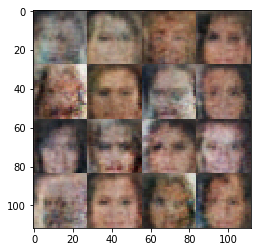

Epoch 1/1... Discriminator Loss: 0.9722... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.0534... Generator Loss: 0.9354
Epoch 1/1... Discriminator Loss: 0.6773... Generator Loss: 1.8637
Epoch 1/1... Discriminator Loss: 0.9176... Generator Loss: 1.3429
Epoch 1/1... Discriminator Loss: 0.7443... Generator Loss: 1.5952
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 1.3973
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.4340
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 1.1221... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 0.8948... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 0.9902... Generator Loss: 1.1580
Epoch 1/1... Discriminator Loss: 1.1461... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 0.7902... Generator Loss: 1.4093
Epoch 1/1... Discriminator Loss: 0.7380... Generator Loss: 1.3206
Epoch 1/1.

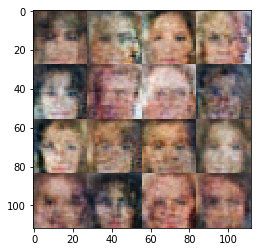

Epoch 1/1... Discriminator Loss: 0.8258... Generator Loss: 1.5448
Epoch 1/1... Discriminator Loss: 0.6743... Generator Loss: 1.7148
Epoch 1/1... Discriminator Loss: 0.7702... Generator Loss: 1.3329
Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.9676
Epoch 1/1... Discriminator Loss: 0.8997... Generator Loss: 1.2258
Epoch 1/1... Discriminator Loss: 1.0428... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 0.6280... Generator Loss: 2.6316
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 0.9512... Generator Loss: 1.0193
Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.0379... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.1574... Generator Loss: 1.0800
Epoch 1/1... Discriminator Loss: 1.1107... Generator Loss: 0.9919
Epoch 1/1... Discriminator Loss: 0.8512... Generator Loss: 1.2225
Epoch 1/1... Discriminator Loss: 0.8347... Generator Loss: 1.6298
Epoch 1/1.

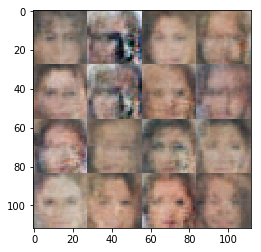

Epoch 1/1... Discriminator Loss: 0.8514... Generator Loss: 1.8408
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.9657
Epoch 1/1... Discriminator Loss: 1.0087... Generator Loss: 1.0776
Epoch 1/1... Discriminator Loss: 0.4602... Generator Loss: 3.5363
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.8544
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.0226... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 0.8217... Generator Loss: 1.4468
Epoch 1/1... Discriminator Loss: 1.2101... Generator Loss: 0.7978
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 1.2808
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 0.9377
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 0.8819... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 0.5314... Generator Loss: 1.9471
Epoch 1/1.

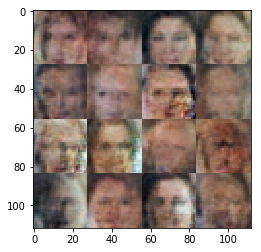

Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 0.8395... Generator Loss: 1.4327
Epoch 1/1... Discriminator Loss: 0.9223... Generator Loss: 1.3229
Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 0.8541
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 0.5995... Generator Loss: 1.6938
Epoch 1/1... Discriminator Loss: 0.7009... Generator Loss: 1.6544
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.1119
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 1.1971
Epoch 1/1... Discriminator Loss: 0.6698... Generator Loss: 1.2289
Epoch 1/1... Discriminator Loss: 0.8338... Generator Loss: 1.4295
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.0161
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 1.3990
Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 0.9314
Epoch 1/1.

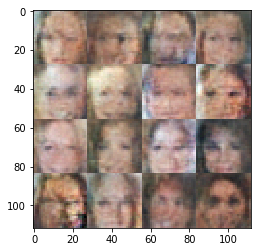

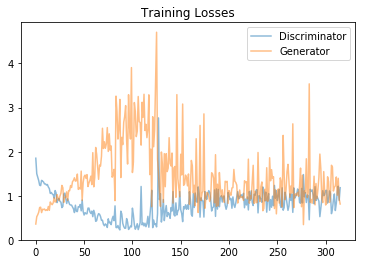

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.